# Multi-Label Movie Genre Classification


*   This notebook trains a TensorFlow neural network for multi-label movie genre classification
using a dataset of movie titles, descriptions, and genres.

*   The model predicts multiple genres
for each movie (e.g., "Action, Sci-Fi") and is designed for deployment to a backend website.

The notebook includes data preprocessing, model training, evaluation, and visualizations to analyze performance.





# Import required libraries for data processing, modeling, and visualization.

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

# Parameters

In [ ]:
VOCAB_SIZE = 10000      # Maximum vocabulary size for TextVectorization
MAX_LENGTH = 200       # Maximum sequence length for tokenized texts
EMBEDDING_DIM = 128    # Embedding dimension for word vectors
BATCH_SIZE = 32        # Batch size for training
EPOCHS = 20            # Maximum number of training epochs

# Data Loading
Load the training and test datasets from text files.
 - Train data format: ID ::: TITLE ::: GENRE ::: DESCRIPTION
 - Test data format: ID ::: TITLE ::: DESCRIPTION

In [25]:
def load_data(train_path, test_path):
    try:
        train_df = pd.read_csv(train_path, sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine='python')
        test_df = pd.read_csv(test_path, sep=':::', names=['ID', 'TITLE', 'DESCRIPTION'], engine='python')
        print(f"Loaded {len(train_df)} training samples and {len(test_df)} test samples.")
        return train_df, test_df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

train_path = 'train_data.txt'
test_path = 'test_data.txt'
train_df, test_df = load_data(train_path, test_path)

Loaded 54214 training samples and 54200 test samples.


# Data Preprocessing
Preprocess the text data and encode genres:

*   Clean text by removing non-UTF-8 characters and normalizing whitespace.
*   Combine TITLE and DESCRIPTION into a single text field.
*   Validate texts to ensure they are strings.
*   Encode genres using MultiLabelBinarizer for multi-label classification.
*   Print the genre distribution to check for class imbalance.


In [26]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    # Remove non-UTF-8 characters and excessive whitespace
    text = text.encode('utf-8', errors='ignore').decode('utf-8')
    text = re.sub(r'\s+', ' ', text.strip())
    return text

Found 27 unique genres: ['action' 'adult' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'game-show' 'history' 'horror'
 'music' 'musical' 'mystery' 'news' 'reality-tv' 'romance' 'sci-fi'
 'short' 'sport' 'talk-show' 'thriller' 'war' 'western']


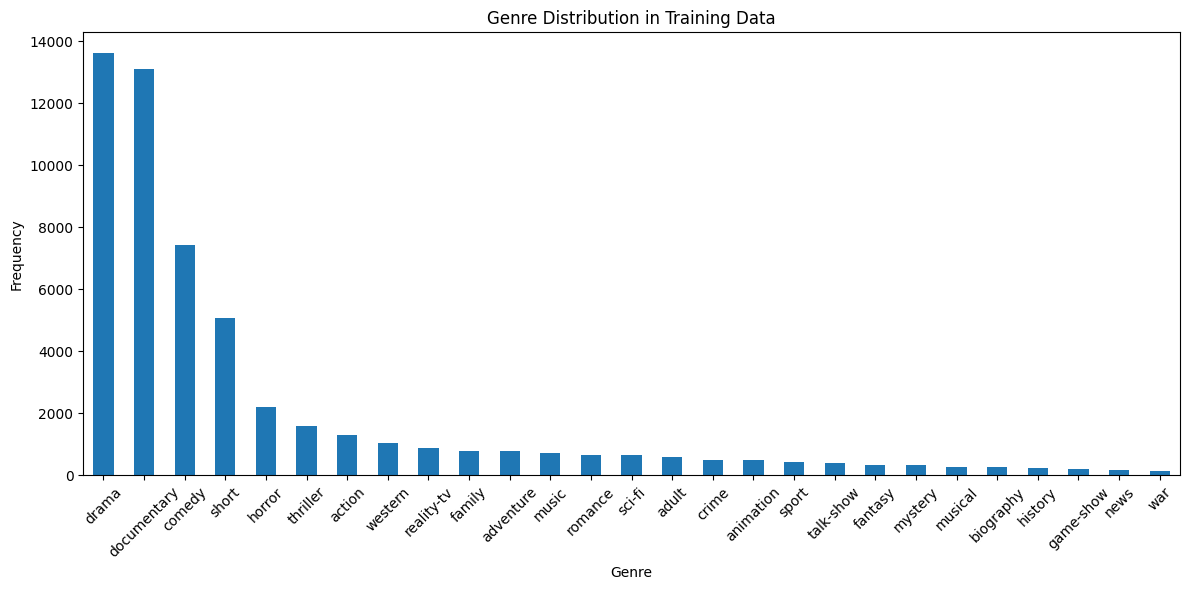

In [27]:
def preprocess_data(train_df, test_df):
    # Handle missing values and ensure string type
    train_df['TITLE'] = train_df['TITLE'].fillna('').astype(str).apply(clean_text)
    train_df['DESCRIPTION'] = train_df['DESCRIPTION'].fillna('').astype(str).apply(clean_text)
    test_df['TITLE'] = test_df['TITLE'].fillna('').astype(str).apply(clean_text)
    test_df['DESCRIPTION'] = test_df['DESCRIPTION'].fillna('').astype(str).apply(clean_text)

    # Combine title and description
    train_texts = (train_df['TITLE'] + " " + train_df['DESCRIPTION']).str.lower().tolist()
    test_texts = (test_df['TITLE'] + " " + test_df['DESCRIPTION']).str.lower().tolist()

    # Validate train_texts
    for i, text in enumerate(train_texts):
        if not isinstance(text, str) or len(text) == 0:
            print(f"Invalid text at index {i}: {text} (type: {type(text)})")
            train_texts[i] = "unknown"

    # Encode genres
    train_df['GENRE'] = train_df['GENRE'].apply(lambda x: x.strip().split(', ') if isinstance(x, str) and x.strip() else ['Unknown'])
    mlb = MultiLabelBinarizer()
    train_labels = mlb.fit_transform(train_df['GENRE'])
    print(f"Found {len(mlb.classes_)} unique genres: {mlb.classes_}")

    # Visualize genre distribution
    genre_counts = train_df['GENRE'].explode().value_counts()
    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar')
    plt.title('Genre Distribution in Training Data')
    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return train_texts, test_texts, train_labels, mlb

train_texts, test_texts, train_labels, mlb = preprocess_data(train_df, test_df)

# Text Vectorization
Pre-vectorize texts to convert them into integer sequences before training:
- Use TextVectorization to tokenize and encode texts.
- Adapt the vectorizer on the training texts to build the vocabulary.
- Convert texts to fixed-length sequences for input to the model.
- Print sample tokenized text to verify vectorization.

In [28]:
def pre_vectorize_texts(texts, vectorizer):
    vectorizer.adapt(texts)
    vectorized_texts = vectorizer(texts).numpy()
    return vectorized_texts

vectorizer = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)
train_texts_vectorized = pre_vectorize_texts(train_texts, vectorizer)
print("Texts pre-vectorized.")

# Debug: Print sample tokenized text
sample_text = train_texts[0]
sample_vectorized = vectorizer(np.array([sample_text])).numpy()[0]
print(f"Sample text: {sample_text[:100]}...")
print(f"Tokenized: {sample_vectorized[:20]}...")

Texts pre-vectorized.
Sample text: oscar et la dame rose (2009) listening in to a conversation between his doctor and parents, 10-year-...
Tokenized: [2971 1031  202 8707 1349  229 5178    7    6    4 1980   97    9  524
    3  223 9262 2971  452   55]...


# Model Building
Build a neural network for multi-label classification:
- Input: Pre-vectorized text sequences (shape=(MAX_LENGTH,)).
- Layers: Embedding, GlobalAveragePooling1D, Dense (256), Dense (128), Dense (num_genres).
- Output: Sigmoid activation for multi-label predictions.
- The model is simple but effective for text classification.

In [29]:
def build_model(vocab_size, max_length, embedding_dim, num_genres):
    inputs = Input(shape=(max_length,), dtype=tf.int32)
    x = Embedding(vocab_size, embedding_dim)(inputs)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_genres, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_model(VOCAB_SIZE, MAX_LENGTH, EMBEDDING_DIM, len(mlb.classes_))
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,349,403 (5.15 MB)

 Trainable params: 1,349,403 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

# Dataset Creation
Create TensorFlow datasets for training and validation:
- Convert pre-vectorized texts and labels into a tf.data.Dataset.
- Cache, batch, and prefetch for efficient training.
- Split into training and validation datasets (80-20 split).

In [30]:
def create_dataset(texts, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_texts_vectorized, train_labels, BATCH_SIZE)
val_size = int(0.2 * len(train_texts))
val_dataset = train_dataset.take(val_size // BATCH_SIZE)
train_dataset = train_dataset.skip(val_size // BATCH_SIZE)


# Model Training
Train the model with the following setup:
- Optimizer: Adam
- Loss: Binary cross-entropy (suitable for multi-label classification)
- Metrics: Precision
- Callbacks: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
- The model saves the best weights based on validation precision.

In [31]:
def train_model(model, train_dataset, val_dataset):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision'])
    callbacks = [
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint('movie_genre_model.keras', save_best_only=True, monitor='val_precision'),
        ReduceLROnPlateau(factor=0.5, patience=2)
    ]
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    return history

history = train_model(model, train_dataset, val_dataset)

Epoch 1/20
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.1570 - precision: 0.2314 - val_loss: 0.1036 - val_precision: 0.7513 - learning_rate: 0.0010
Epoch 2/20
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.1025 - precision: 0.6832 - val_loss: 0.0974 - val_precision: 0.6764 - learning_rate: 0.0010
Epoch 3/20
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0913 - precision: 0.7125 - val_loss: 0.0897 - val_precision: 0.6636 - learning_rate: 0.0010
Epoch 4/20
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0828 - precision: 0.7279 - val_loss: 0.0877 - val_precision: 0.6460 - learning_rate: 0.0010
Epoch 5/20
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0771 - precision: 0.7547 - val_loss: 0.0833 - val_precision: 0.6781 - learning_rate: 0.0010
Epoch 6/20
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0723 - precision: 0.7700 - val_loss: 0.0812 - val_precision: 0.6945 - learning_rate: 0.0010
Epoch 7/20
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/s

# Training Visualization
Plot training and validation loss and precision to assess convergence:
- Loss plot: Shows how well the model optimizes.
- Precision plot: Tracks the proportion of correct positive predictions.

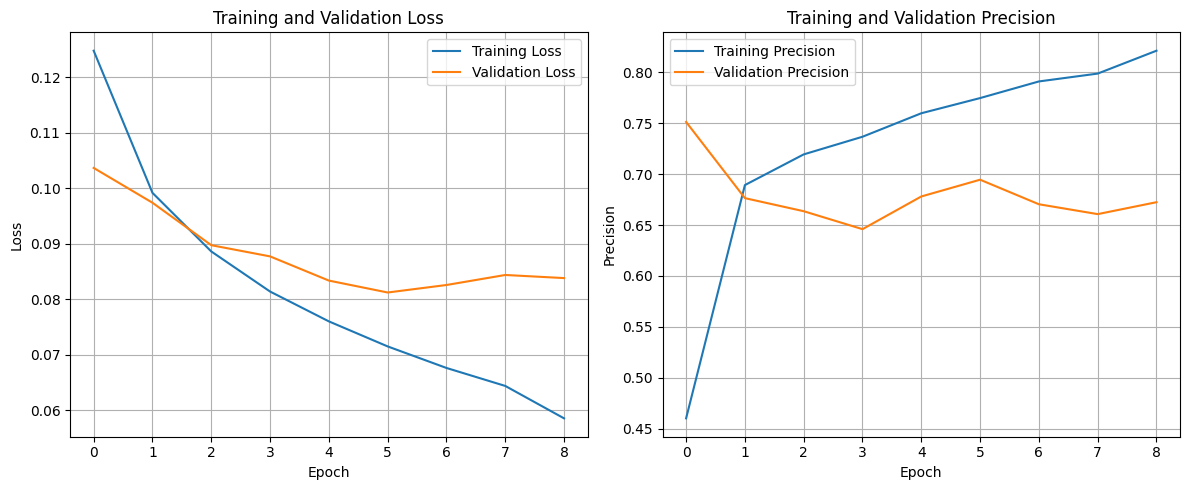

In [32]:
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot precision
    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Model Evaluation
Evaluate the model on the validation set (last 20% of training data):
- Compute precision, recall, and F1-score (weighted averages).
- Generate a confusion matrix heatmap for each genre to visualize performance.

339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


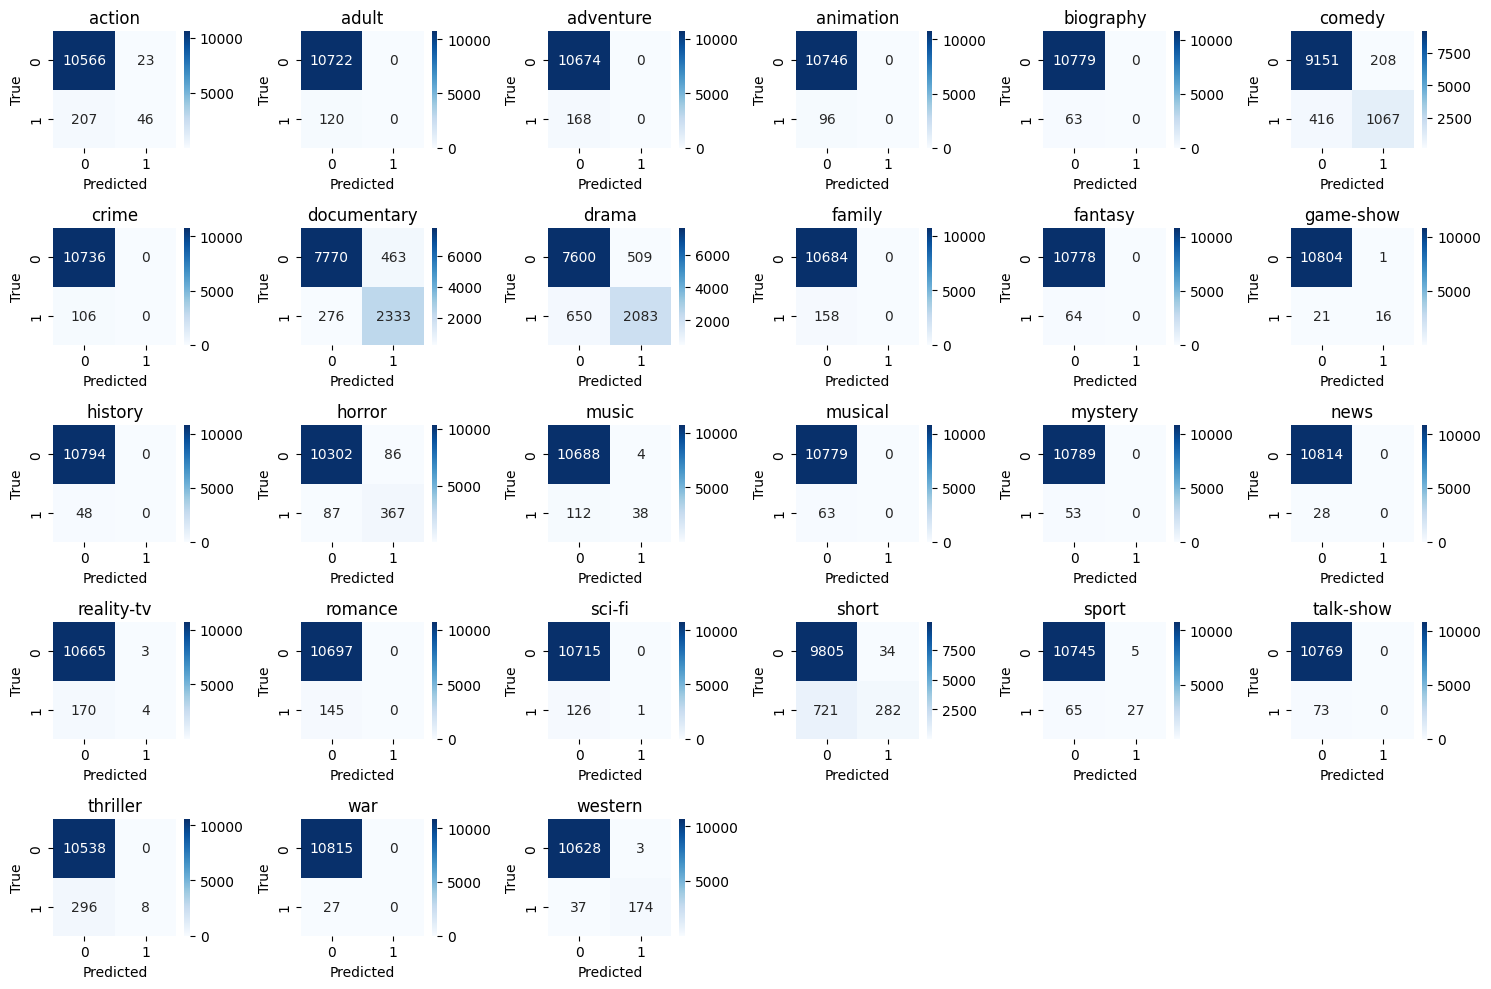

Validation Precision: 0.7408, Recall: 0.5945, F1: 0.6219


In [33]:
def evaluate_model(model, val_texts, val_labels, vectorizer):
    val_texts = np.array(val_texts, dtype=str)
    val_texts_vectorized = vectorizer(val_texts).numpy()
    val_preds = model.predict(val_texts_vectorized)
    val_preds_binary = (val_preds > 0.5).astype(int)

    precision = precision_score(val_labels, val_preds_binary, average='weighted')
    recall = recall_score(val_labels, val_preds_binary, average='weighted')
    f1 = f1_score(val_labels, val_preds_binary, average='weighted')

    # Confusion matrix for each genre
    cm = multilabel_confusion_matrix(val_labels, val_preds_binary)
    plt.figure(figsize=(15, 10))
    for i, genre in enumerate(mlb.classes_):
        plt.subplot(5, 6, i+1)
        sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
        plt.title(f'{genre}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return precision, recall, f1

val_texts = train_texts[-int(0.2*len(train_texts)):]
val_labels = train_labels[-int(0.2*len(train_labels)):]
precision, recall, f1 = evaluate_model(model, val_texts, val_labels, vectorizer)
print(f"Validation Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

In [34]:
def analyze_prediction(title, description, model, vectorizer, mlb):
    text = (title + " " + description).lower()
    text_vectorized = vectorizer(np.array([text], dtype=str)).numpy()
    probs = model.predict(text_vectorized)[0]

    # Print probabilities
    print(f"Prediction probabilities for '{title}':")
    for genre, prob in zip(mlb.classes_, probs):
        print(f"{genre}: {prob:.4f}")

    # Visualize probabilities
    plt.figure(figsize=(12, 6))
    plt.bar(mlb.classes_, probs)
    plt.title(f'Prediction Probabilities for "{title}"')
    plt.xlabel('Genre')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Test different thresholds
    thresholds = [0.3, 0.4, 0.5]
    for thresh in thresholds:
        pred_binary = (probs > thresh).astype(int)
        genres = [mlb.classes_[i] for i, val in enumerate(pred_binary) if val == 1]
        print(f"Genres at threshold {thresh}: {genres}")

    return probs

# Example Prediction
Test the model with a sample input to demonstrate prediction:
- Input: A movie title and description.
- Output: Predicted genres based on the trained model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction probabilities for 'Radhe Shyam':
action: 0.0039
adult: 0.0007
adventure: 0.0021
animation: 0.0006
biography: 0.0023
comedy: 0.0960
crime: 0.0077
documentary: 0.0064
drama: 0.7462
family: 0.0088
fantasy: 0.0013
game-show: 0.0000
history: 0.0005
horror: 0.0031
music: 0.0002
musical: 0.0021
mystery: 0.0028
news: 0.0000
reality-tv: 0.0002
romance: 0.0241
sci-fi: 0.0007
short: 0.0571
sport: 0.0001
talk-show: 0.0000
thriller: 0.0238
war: 0.0004
western: 0.0008


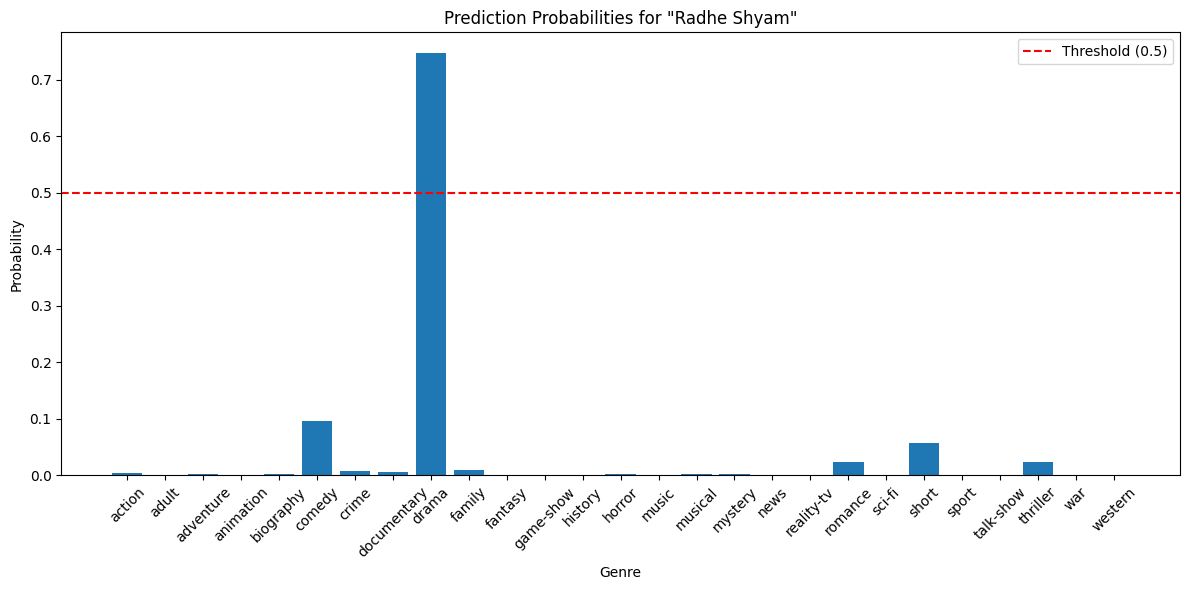

Genres at threshold 0.3: ['drama']
Genres at threshold 0.4: ['drama']
Genres at threshold 0.5: ['drama']


In [38]:
title = "Radhe Shyam"
description = "a world-renowned palmist named Vikramaditya finds love when he meets Prerana, a doctor. However, their relationship is threatened by his view of destiny and a terminal illness."
probs = analyze_prediction(title, description, model, vectorizer, mlb)


# Save Model and Artifacts
Save the trained model, genre encoder, and vectorizer configuration:
- Model: Saved in native Keras format (.keras).
- MultiLabelBinarizer: Saved as numpy array for genre decoding.
- Vectorizer: Saved as configuration for use in prediction.

In [20]:
def save_artifacts(model, mlb, vectorizer):
    model.save('movie_genre_model.keras')
    np.save('mlb_classes.npy', mlb.classes_)
    vectorizer_config = {
        'vocab': vectorizer.get_vocabulary(),
        'max_tokens': VOCAB_SIZE,
        'output_sequence_length': MAX_LENGTH
    }
    np.save('vectorizer_config.npy', vectorizer_config)
    print("Model and artifacts saved.")

save_artifacts(model, mlb, vectorizer)

Model and artifacts saved.
